## Методы машинного обучения в мониторинге акваторий с помощью ДЗЗ

Постановка задачи: на вход даются подаются спутниковые снимки акваторий в видимом диапазоне. Модель должна определять, есть ли на них загрязнения.

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from VisExtract import VisExtract
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

Импорт зависимостей. В классе VisExtract реализованно построение изображений в пространстве RGB. Также происходит StandartScale нормировка.

Постановка задачи: на вход подаются спутниковые снимки в видимом диапазоне. Модель должна определять участки загрязнения для выбранной области интереса. Выделим три класса: отсутствие загрязнения (0), загрязнение (1), корабль 
(2).

Выведем данные, как они есть:

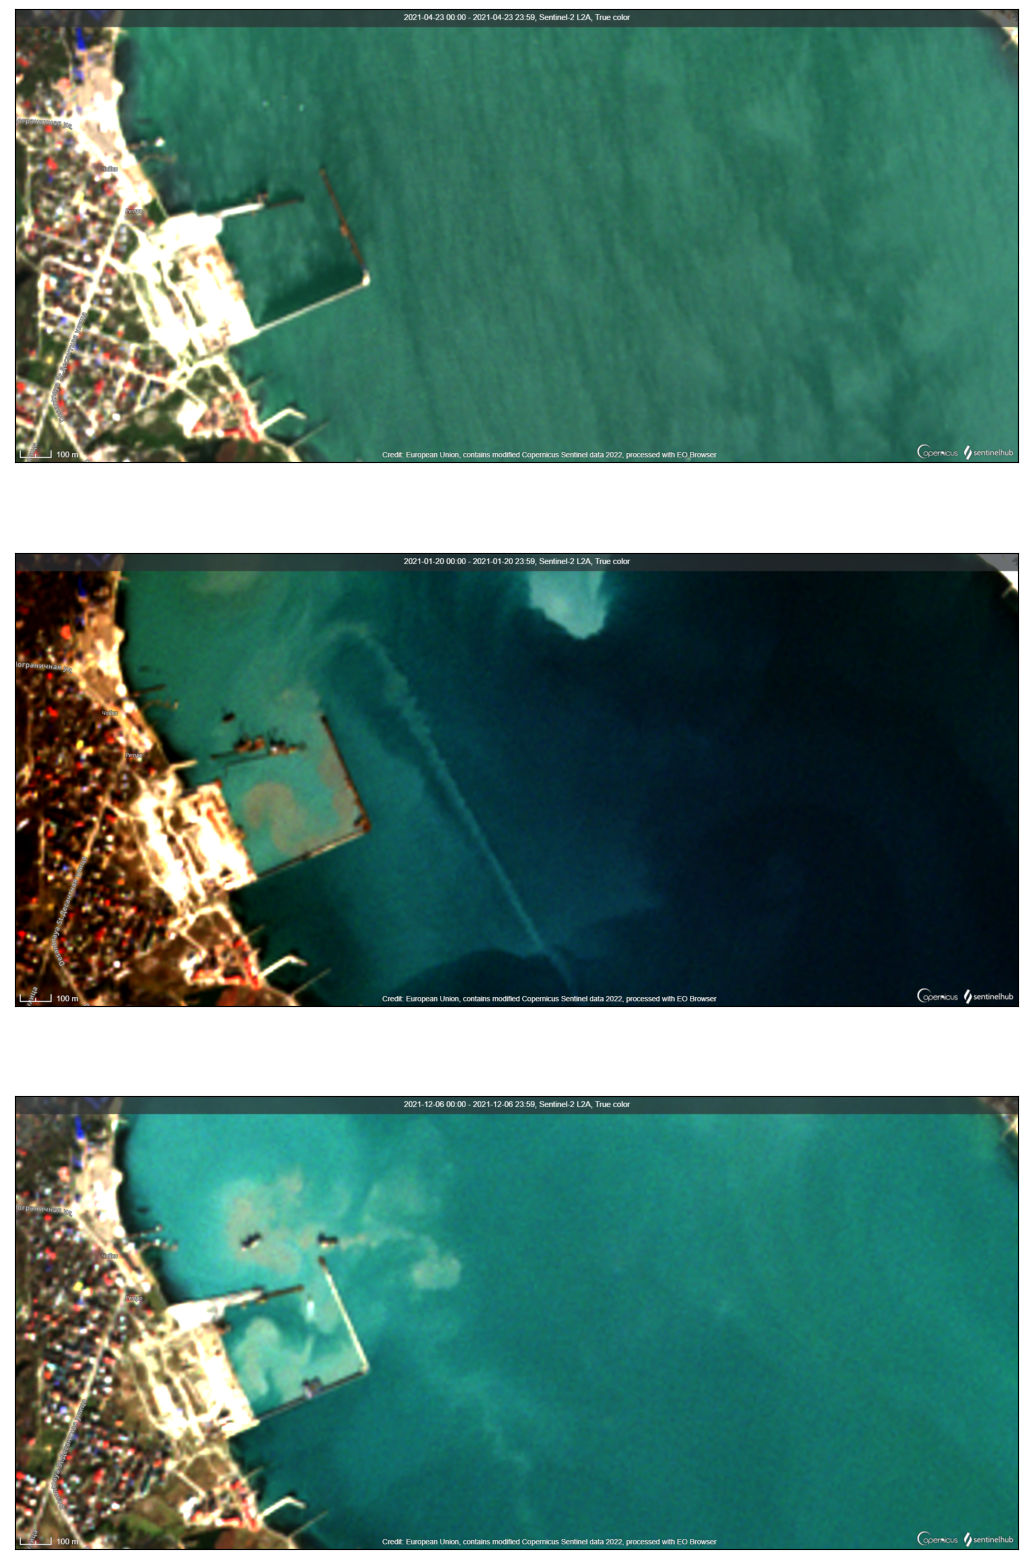

In [3]:
np.random.seed(23)
filelist = np.random.choice(os.listdir('unsplited'), size=4)
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
l = lambda pth: cv2.cvtColor(cv2.imread(f'unsplited/{pth}'), cv2.COLOR_RGB2BGR)

for i in range(1, 4):
    axarr[i - 1].imshow(l(filelist[i]))
    axarr[i - 1].set_xticks([]), axarr[i - 1].set_yticks([])

Разобьем область интереса на мелкие части:

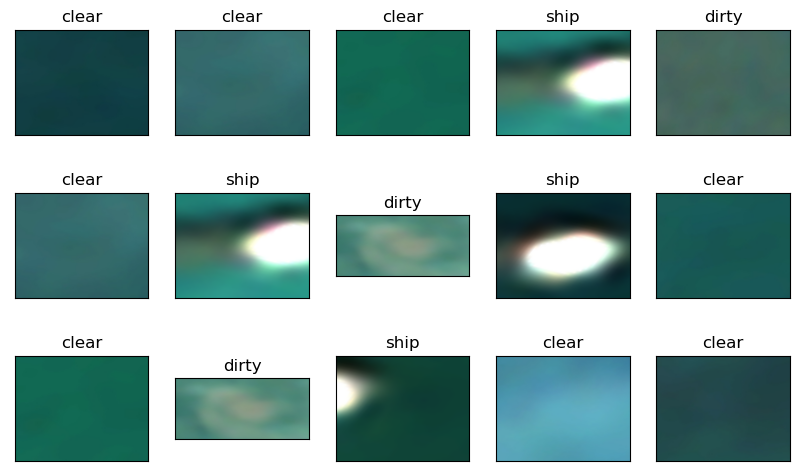

In [4]:
n_rows = 3
n_cols = 5

np.random.seed(34)
filelist = np.random.choice(os.listdir('data'), size=n_cols * n_cols)

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 6))

l = lambda pth: cv2.cvtColor(cv2.imread(f'data/{pth}'), cv2.COLOR_RGB2BGR)

name = {'0': 'clear', '1': 'dirty', '2': 'ship'}


for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        axarr[i - 1, j - 1].imshow(l(filelist[i * j]))
        axarr[i - 1, j - 1].set_xticks([]), axarr[i - 1, j - 1].set_yticks([])
        axarr[i - 1, j - 1].set_title(name[filelist[i * j][0]])

Начнём с самого наивного подхода, будем высчитывать средние по изображениям.
Представим данные в пространстве, координаты - средние значения RGB каналов.

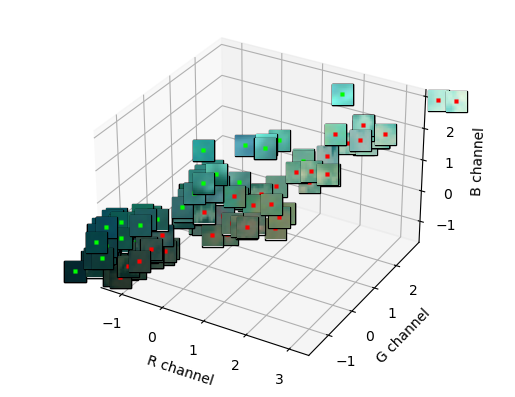

In [5]:
vis = VisExtract('data', len(os.listdir('data')), 'show')

Видно, что при таком количестве классов данные неплохо разделимы и линейно.

In [6]:
(trainData, testData, trainLabels, testLabels) = train_test_split(vis.data, vis.y, test_size=0.3, random_state=41)

Обучим модель логистической регрессии:

In [8]:
model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(trainData, trainLabels)

Построим разделяющую плоскость:

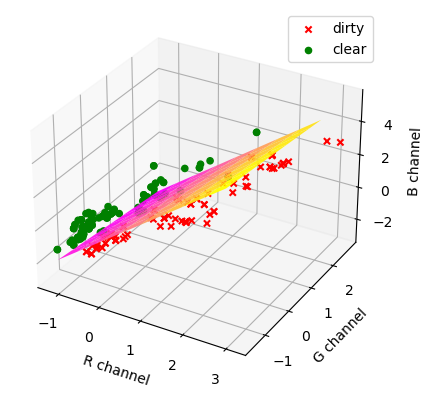

In [9]:
vis.add_hyperplane(list((model.coef_[0][0], model.coef_[0][1], model.coef_[0][2], model.intercept_[0])))

Выведем метрики качества:

In [11]:
predLabels = model.predict(testData)
from sklearn.metrics import classification_report
print(classification_report(testLabels, predLabels, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.949     0.974        39
           1      0.929     1.000     0.963        26

    accuracy                          0.969        65
   macro avg      0.964     0.974     0.968        65
weighted avg      0.971     0.969     0.969        65



Действительно, данные отлично разделимы линейно. Однако, это решение задачи классификации clear vs. dirty, но ведь на изображении могут быть и корабли. Смотрим:

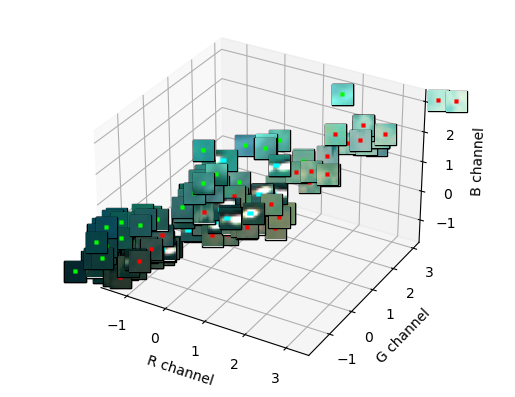

In [12]:
vis = VisExtract('data', len(os.listdir('data')), 'show', ships=True)

Если представить данные в RGB пространстве, используя как предиктор среднее значение по каналу RGB, то разделить их на три класса не выйдет. Попробуем использовать как предикторы гисторгаммы изображений.

In [13]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [14]:
imagePaths = sorted(list(os.listdir('data')))
data = []
labels = []

for file in imagePaths:
    image = cv2.imread(f'data/{file}', 1)
    label = file[0]
    hist = extract_histogram(image)
    data.append(hist)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [15]:
(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.3, random_state=41)

Используем метод опорных векторов с мягким зазором, используя сеточный подбор гиперпараметров.

In [16]:
params = {'kernel':('linear', 'rbf', 'sigmoid'), 'C': np.linspace(0.1, 10, 50)}
model_svc = svm.SVC(random_state=41)

В качестве метрики используем F1-score-micro.

In [36]:
finder_svc = GridSearchCV(model_svc, params, scoring='f1_micro')
finder_svc.fit(data, labels)

GridSearchCV(estimator=SVC(random_state=41),
             param_grid={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.14081633,  4.34285714,  4.54489796,  4.74693878,  4.94897959,
        5.15102041,  5.35306122,  5.55510204,  5.75714286,  5.95918367,
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ])},
             scoring='f1_micro')

Посмотрим на результаты:

In [42]:
svc_res_df = pd.DataFrame(finder_svc.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
svc_res_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.008242,0.000253,0.003702,0.000109,1.716327,{'C': 1.716326530612245},0.8,0.944444,0.962963,0.870370,0.87037,0.889630,0.058579,1
23,0.007550,0.000184,0.003446,0.000172,4.746939,{'C': 4.746938775510204},0.8,0.944444,0.962963,0.851852,0.87037,0.885926,0.060242,2
18,0.007910,0.000300,0.003532,0.000087,3.736735,{'C': 3.736734693877551},0.8,0.944444,0.962963,0.851852,0.87037,0.885926,0.060242,2
17,0.008170,0.000219,0.003768,0.000274,3.534694,{'C': 3.5346938775510206},0.8,0.944444,0.962963,0.851852,0.87037,0.885926,0.060242,2
16,0.008274,0.000173,0.003909,0.000325,3.332653,{'C': 3.33265306122449},0.8,0.944444,0.962963,0.851852,0.87037,0.885926,0.060242,2


Проделаем то же с логистической регрессией:

In [19]:
params = {'C': np.linspace(0.1, 10, 50)}
model_lr = LogisticRegression(random_state=41)

In [38]:
finder_lr = GridSearchCV(model_lr, params, scoring='f1_micro')
finder_lr.fit(data, labels)

GridSearchCV(estimator=LogisticRegression(random_state=41),
             param_grid={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.14081633,  4.34285714,  4.54489796,  4.74693878,  4.94897959,
        5.15102041,  5.35306122,  5.55510204,  5.75714286,  5.95918367,
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ])},
             scoring='f1_micro')

In [43]:
lr_res_df = pd.DataFrame(finder_lr.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
lr_res_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.066397,0.024847,0.002537,0.000556,5.15102,{'C': 5.151020408163265},0.836364,0.981481,0.962963,0.888889,0.87037,0.908013,0.055378,1
42,0.106418,0.031117,0.002232,0.000108,8.585714,{'C': 8.585714285714285},0.836364,0.981481,0.962963,0.888889,0.87037,0.908013,0.055378,1
48,0.078217,0.015291,0.002372,0.000190,9.797959,{'C': 9.79795918367347},0.836364,0.981481,0.962963,0.888889,0.87037,0.908013,0.055378,1
47,0.065770,0.006706,0.002269,0.000018,9.595918,{'C': 9.595918367346938},0.836364,0.981481,0.962963,0.888889,0.87037,0.908013,0.055378,1
46,0.061408,0.002348,0.002257,0.000006,9.393878,{'C': 9.393877551020408},0.836364,0.981481,0.962963,0.888889,0.87037,0.908013,0.055378,1
